In [159]:
import cv2
import sys
import pytesseract
import glob
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mping
from math import *
import os
import shutil
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
K.set_image_data_format('channels_last')
%matplotlib inline

In [3]:
cnt = 0
for filepath in glob.iglob('new_train/*'):
    # Define config parameters.
    # '-l eng'  for using the English language
    # '--oem 1' for using LSTM OCR Engine
    print(filepath)
    config = ('-l eng --oem 1 --psm 3')

    # Read image from disk
    im = cv2.imread(filepath, cv2.IMREAD_COLOR)

    # Run tesseract OCR on image
    text = pytesseract.image_to_string(im, config=config)

    # Print recognized text
    print(text)
    cnt+=1
    
    if cnt > 10:
        break

new_train/Aglaia_odorata.png

new_train/Ananas_comosus.png

new_train/Aquilaria_malaccensis.png

new_train/Calotropis_gigantea.png

new_train/Cardiospermum_halicacabum.png

new_train/Crinum_asiaticum.png

new_train/Eriobotrya_japonica.png

new_train/Eurycoma_longifolia.png

new_train/Gacinia_atroviridis.png

new_train/Garcinia_gummi_gutaa.png

new_train/Gynura_procumbens.png



In [2]:
# Loading camera calibration
mtx, dist, rvecs, tvecs = pickle.load( open('./calibrations.pickle', 'rb' ))

In [3]:
def resizingImage(img):
    """
    Convert each image into 400*400 size.
    """
    res = cv2.resize(img, (400, 400), interpolation = cv2.INTER_CUBIC)
    return res

In [4]:
def showImages(images, cols = 3, figsize=(25,25), colorspace='rgb', showOriginal=False):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    num_images = len(images)
    rows = (num_images//cols) 
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < num_images:
            imagePathName, img = images[index]
            if len(img.shape) == 3:
                # color space conversion
                if colorspace == 'gray':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                elif colorspace == 'hsv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                elif colorspace == 'hls':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
                elif colorspace == 'lab':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                elif colorspace == 'luv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
                elif colorspace == 'yuv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            
            if showOriginal:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap='gray')
            ax.set_title(imagePathName.split('/')[-1])
            ax.set_xticks([], minor=False)
            ax.set_yticks([], minor=False)

def save_images(outFolder, output_images, suffix=None):
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for imagePath, img in output_images:
        imgName = (imagePath.split('.')[1].split('/')[2] + '_' + suffix + '.jpg') if suffix else (imagePath.split('.')[1].split('/')[2]+'_output.jpg')
        outFile = '%s/%s' % (outFolder, imgName)
        cv2.imwrite(outFile, img)

In [6]:
for filepath in glob.iglob('train_images//*'):
    
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape[:2])
    res = resizingImage(img)
    
    print(res.shape)
    break
    

(4160, 3120)
(400, 400, 3)


In [7]:
def imgUndistort(img, mtx=mtx, dist=dist):
    """
    Undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

In [8]:
def perspective_transform_matrix(img, show_debug=False):
    img_size = img.shape[:2][::-1]
#     print(img_size)
    src = np.float32(\
    [[(img_size[0]), img_size[1]],\
     [((img_size[0])), img_size[1]],\
     [(img_size[0] ), img_size[1]],\
     [(img_size[0]), img_size[1]]]) 

    dst = np.float32(\
    [[(img_size[0]), img_size[1]],\
     [(img_size[0]), img_size[1]],\
     [(img_size[0]), img_size[1]],\
     [(img_size[0]), img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if show_debug == True:
        print("source points")
        print(src)
        print("Transformed points")
        print(dst)

        plt.figure(figsize=(16, 16))
        plt.subplot(1, 2, 1)
        plt.imshow(img) 
        plt.plot(src[:,0], src[:,1], 'rx')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        warped = cv2.warpPerspective(img, M, img_size)
        plt.imshow(warped) 
        plt.plot(dst[:,0], dst[:,1], 'rx')
        plt.title('Perspective Transformed Image')
    
    return M, Minv

source points
[[ 370.  327.]
 [ 370.  327.]
 [ 370.  327.]
 [ 370.  327.]]
Transformed points
[[ 370.  327.]
 [ 370.  327.]
 [ 370.  327.]
 [ 370.  327.]]


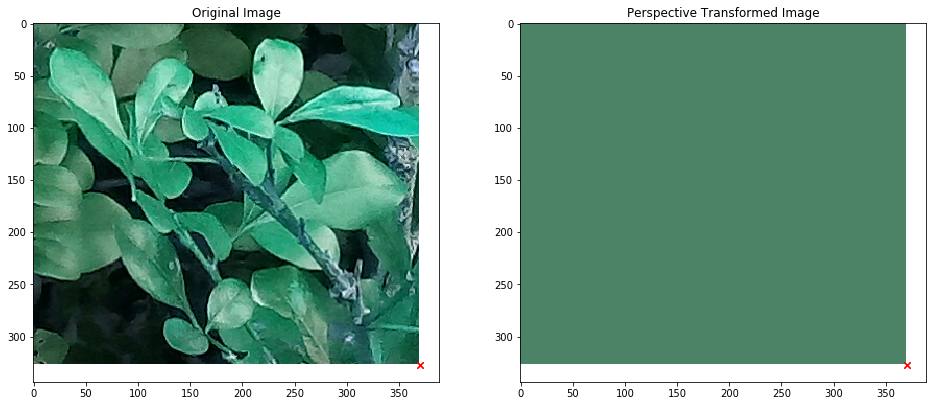

In [11]:
testImage = cv2.imread('train/Aglaia_odorata.png')

M, Minv = perspective_transform_matrix(testImage, show_debug=True)

In [15]:
# Load test images.
trainImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.iglob('train/*')))

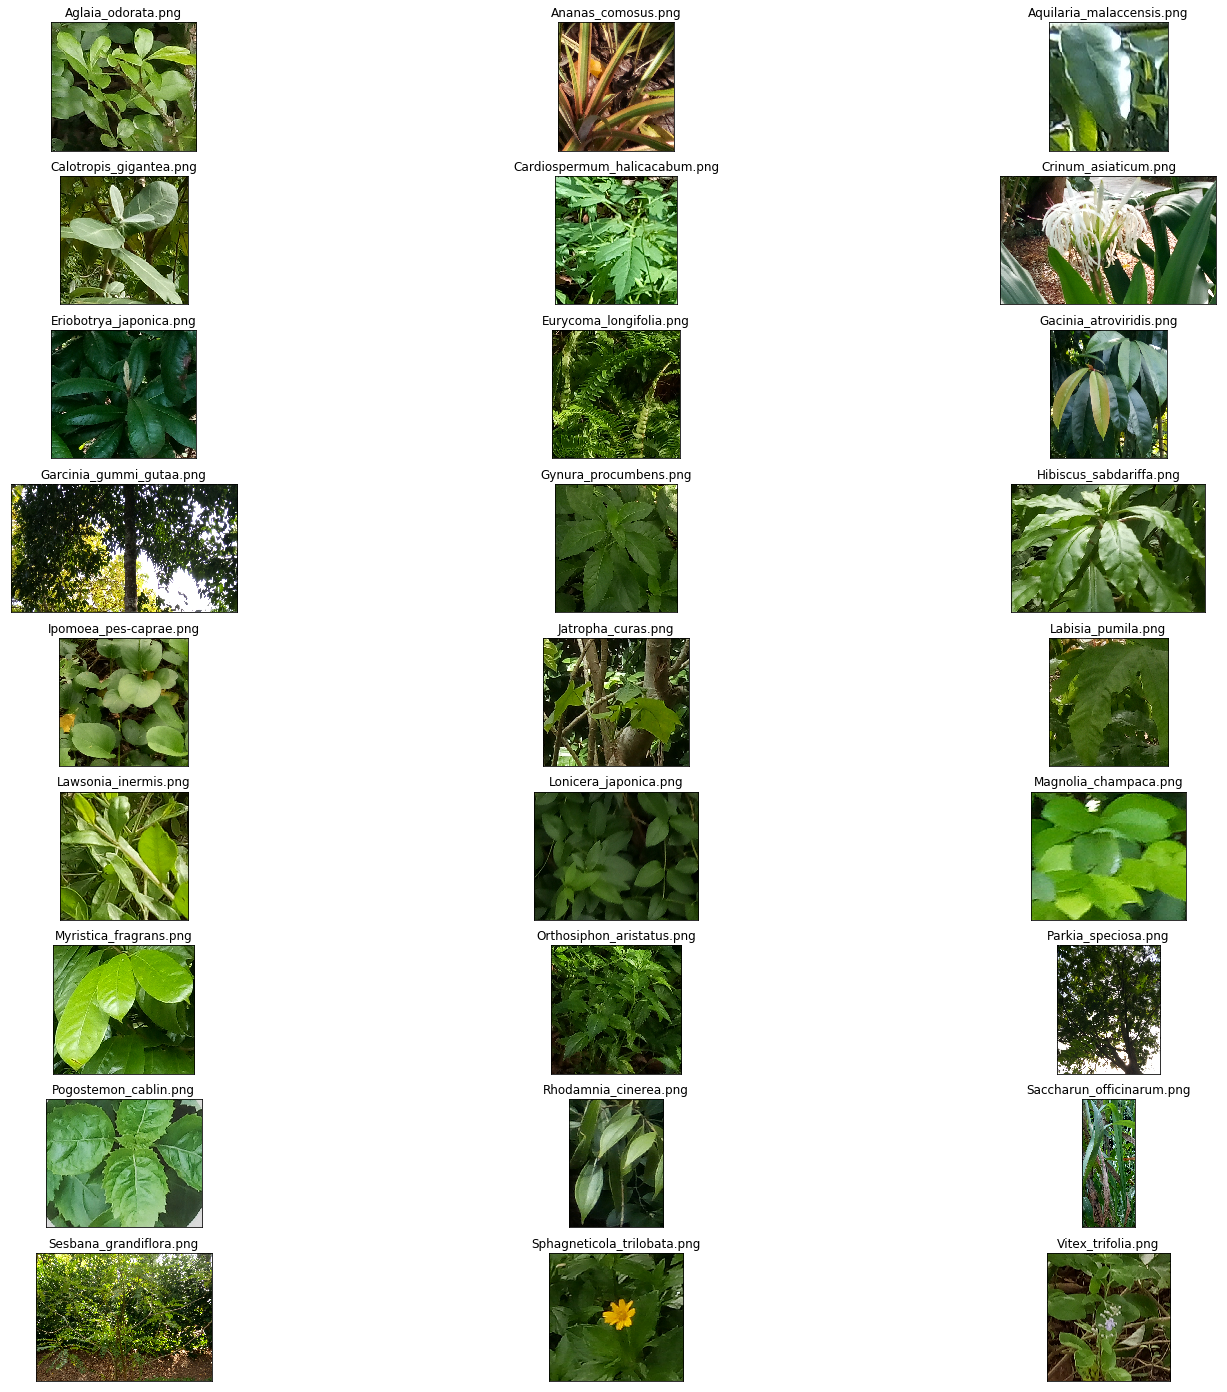

In [16]:
showImages(trainImages, showOriginal=True)

# Image resizing

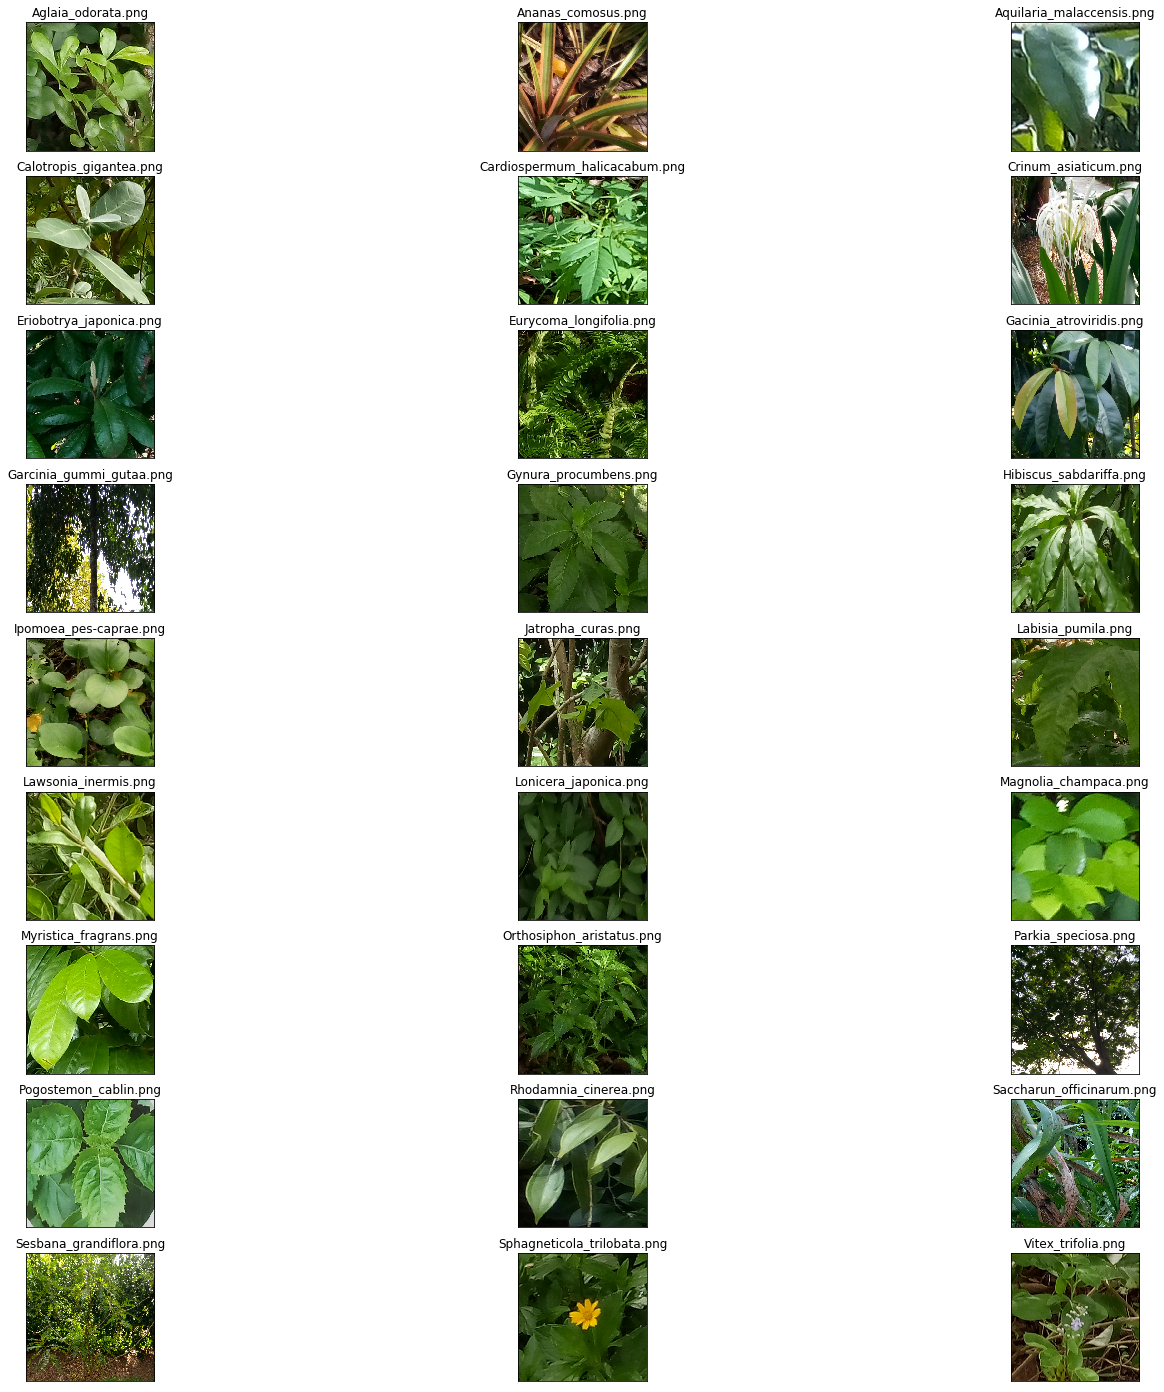

In [17]:
resized_train_images = list(map(lambda image: (image[0], resizingImage(image[1])), trainImages))
showImages(resized_train_images)

# Apply Undistort Function

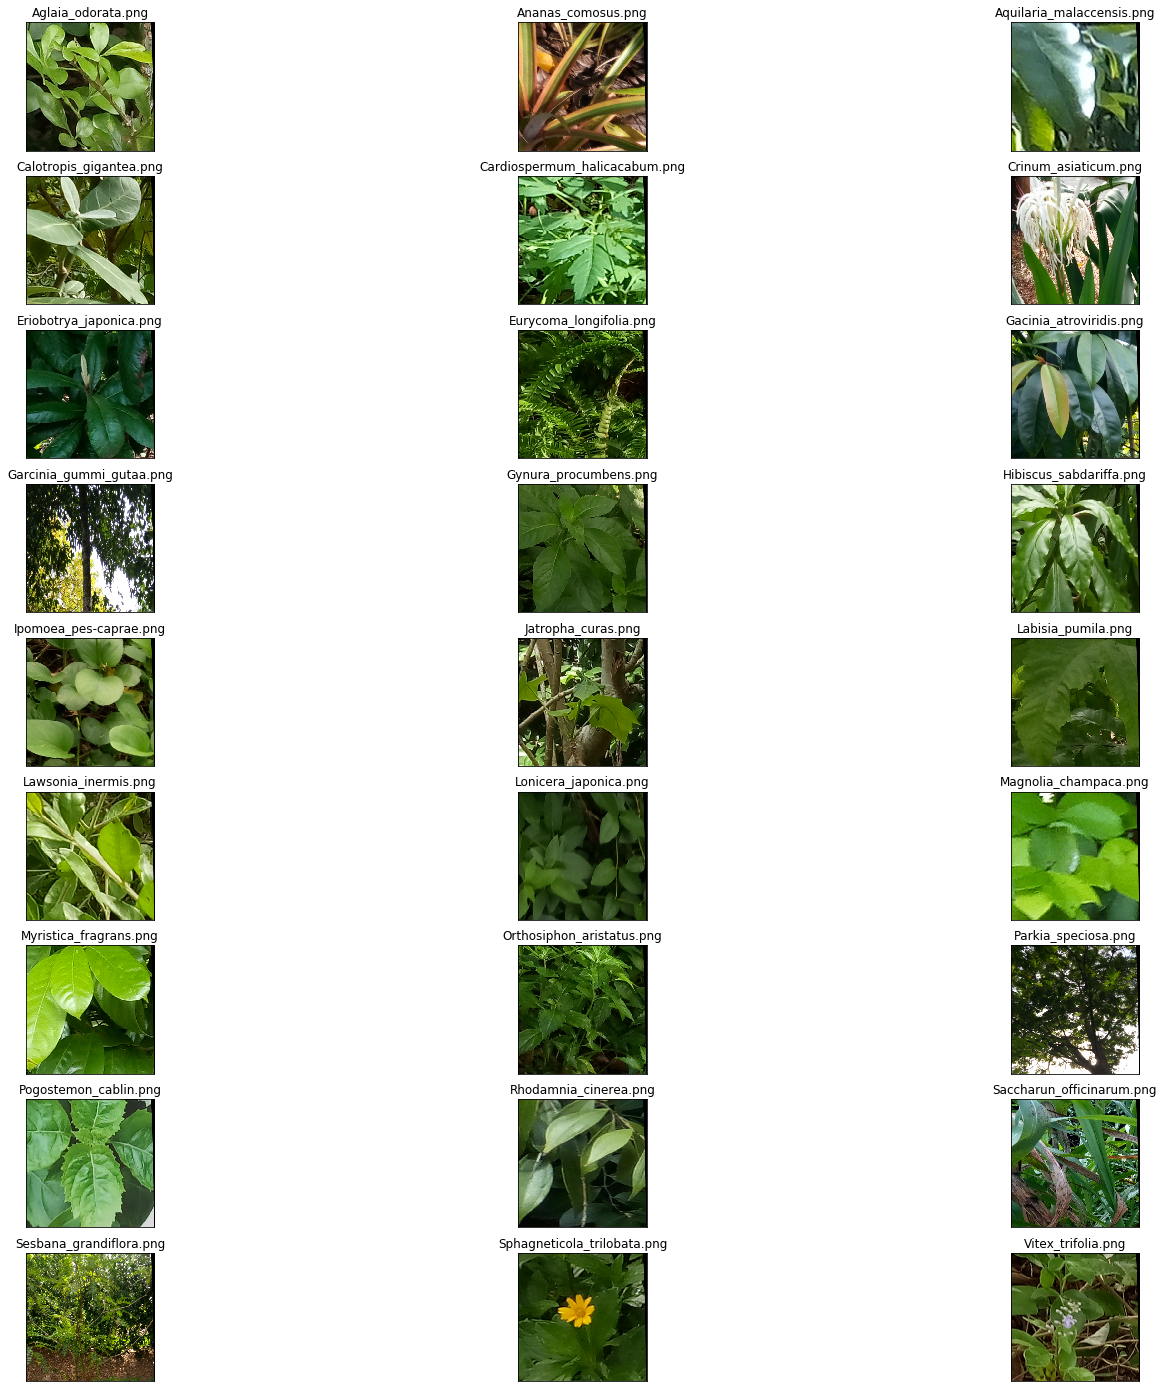

In [18]:
undistort_images = list(map(lambda image: (image[0], imgUndistort(image[1])), resized_train_images))
showImages(undistort_images)

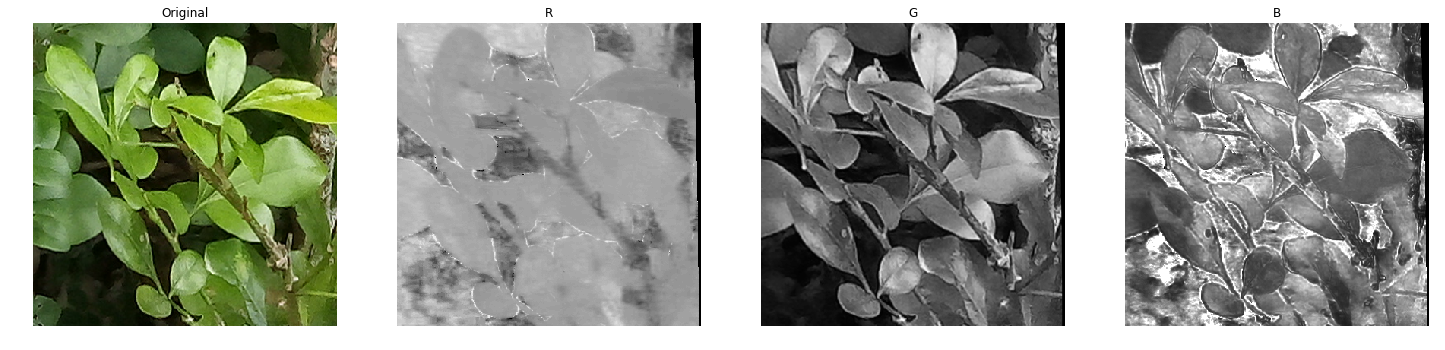

In [19]:
undist = cv2.undistort(resized_train_images[0][1], mtx, dist, None, mtx)
hlsOriginal = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)


fig, axes = plt.subplots(ncols=4, figsize=(25,10))
titles = ['Original', 'R', 'G', 'B']
for index, a in enumerate(axes):
    if index == 0:
        a.imshow(cv2.cvtColor(resized_train_images[0][1], cv2.COLOR_BGR2RGB))
    else:
        a.imshow(hlsOriginal[:,:,index-1], cmap='gray')
    a.axis('off')
    a.set_title(titles[index])

In [20]:
def makeBinaryImage(img, mag_threshold=(0,255), dir_threshold=(0.7, 1.3), mode='simple', sobel_kernel=3):
    '''
    Returns a binary image based on the following inputs
    - threshold
    - threshold mode
    '''
    binary = np.zeros_like(img)
    if mode == 'sobelX':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        binary[(scaled_sobelX >= mag_threshold[0]) & (scaled_sobelX <= mag_threshold[1])] = 1
    elif mode == 'sobelY':
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        binary[(scaled_sobelY >= mag_threshold[0]) & (scaled_sobelY <= mag_threshold[1])] = 1
    elif mode == 'magnitude':
        sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # calculate the magnitude
        sobel_mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
        # scale to 8-bit (0 - 255) and convert to type = np.uint8
        sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
        # create a binary mask where mag thresholds are met
        binary[(sobel_scale >= mag_threshold[0]) & (sobel_scale <= mag_threshold[1])] = 1
    elif mode == 'direction':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        gradients = np.arctan2(scaled_sobelY, scaled_sobelX)
        binary[(gradients >= dir_threshold[0]) & (gradients <= dir_threshold[1])] = 1
    elif mode == 'mag_dir_combined':
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9) 
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=9)

        # Calculate the magnitude of gradient
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))

        #Calculate angle
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

        # Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= mag_threshold[0]) & \
                      (scaled_sobel <= mag_threshold[1]) & \
                      (absgraddir >= dir_threshold[0])   & \
                      (absgraddir <= dir_threshold[1])] = 1
    elif mode == 'mag_color_combined':
        sx_thresh=(20, 50)
        s_thresh=(170, 255)
        l_thresh=(40, 255)
        # Convert to HLS color space and separate the L and S
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
        # Threshold lightness
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
        
        # Stack each channel
        channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
        binary = np.zeros_like(sxbinary)
        binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
        binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    elif mode == 'hls_s_channel':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        binary[(s_channel > mag_threshold[0]) & (s_channel <= mag_threshold[1])] = 1
    elif mode == 'laplacian_s_channel_combined':
        hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
        gray = (0.5*img[:,:,0] + 0.4*img[:,:,1] + 0.1*img[:,:,2]).astype(np.uint8)
        s = hls[:,:,2]

        _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

        total_px = img.shape[0]*img.shape[1]
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
        if cv2.countNonZero(mask_three)/total_px < 0.01:
            laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
            mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

        _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
        mask_two = s_binary

        binary = np.clip(cv2.bitwise_and(gray_binary, 
                            cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')
        binary[:ceil(img.shape[0]//2)] = 0
    else:
        binary[(img >= mag_threshold[0]) & (img <= mag_threshold[1])] = 1  
    return binary

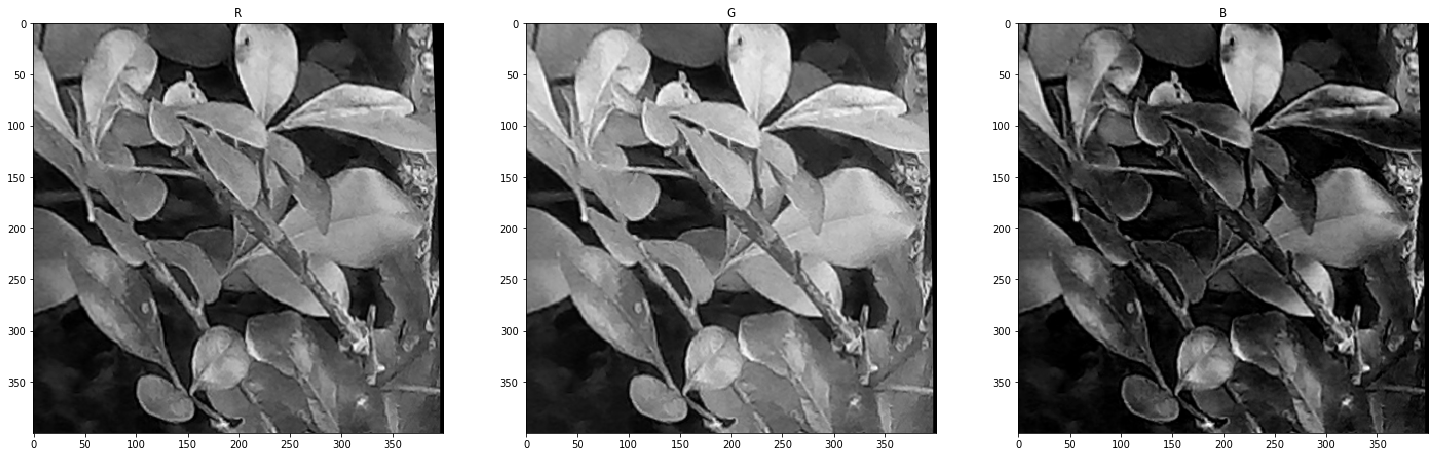

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(undistort_images[0][1], cv2.COLOR_BGR2RGB)[:, :, index], cmap='gray')
    ax.set_title(titles[index+1])

In [22]:
def applyAndShow(images, mag_threshold=(0,255), dir_threshold=(0.7,1.3), sobel_kernel=3, action='simple'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = list(map(lambda img: (img[0], makeBinaryImage(cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB), mag_threshold, dir_threshold, action, sobel_kernel)), images))
    showImages( output, colorspace='gray')
    return output

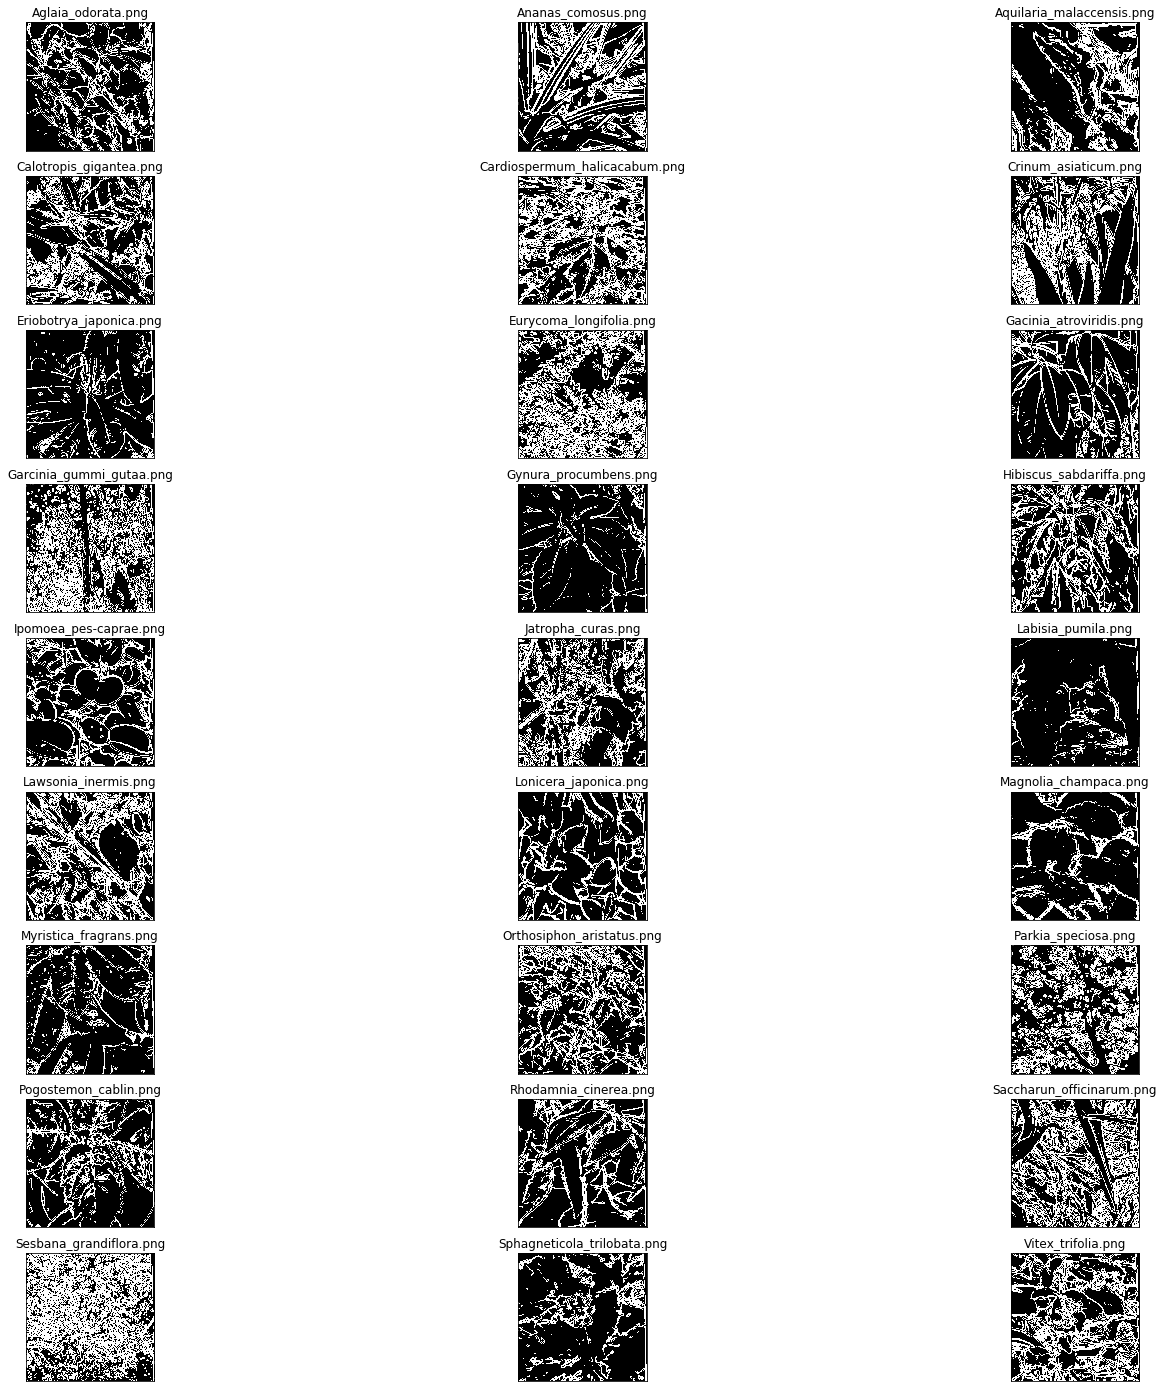

In [23]:
mag_binary_output = applyAndShow(undistort_images, mag_threshold=(20,100), sobel_kernel=9, action='magnitude')

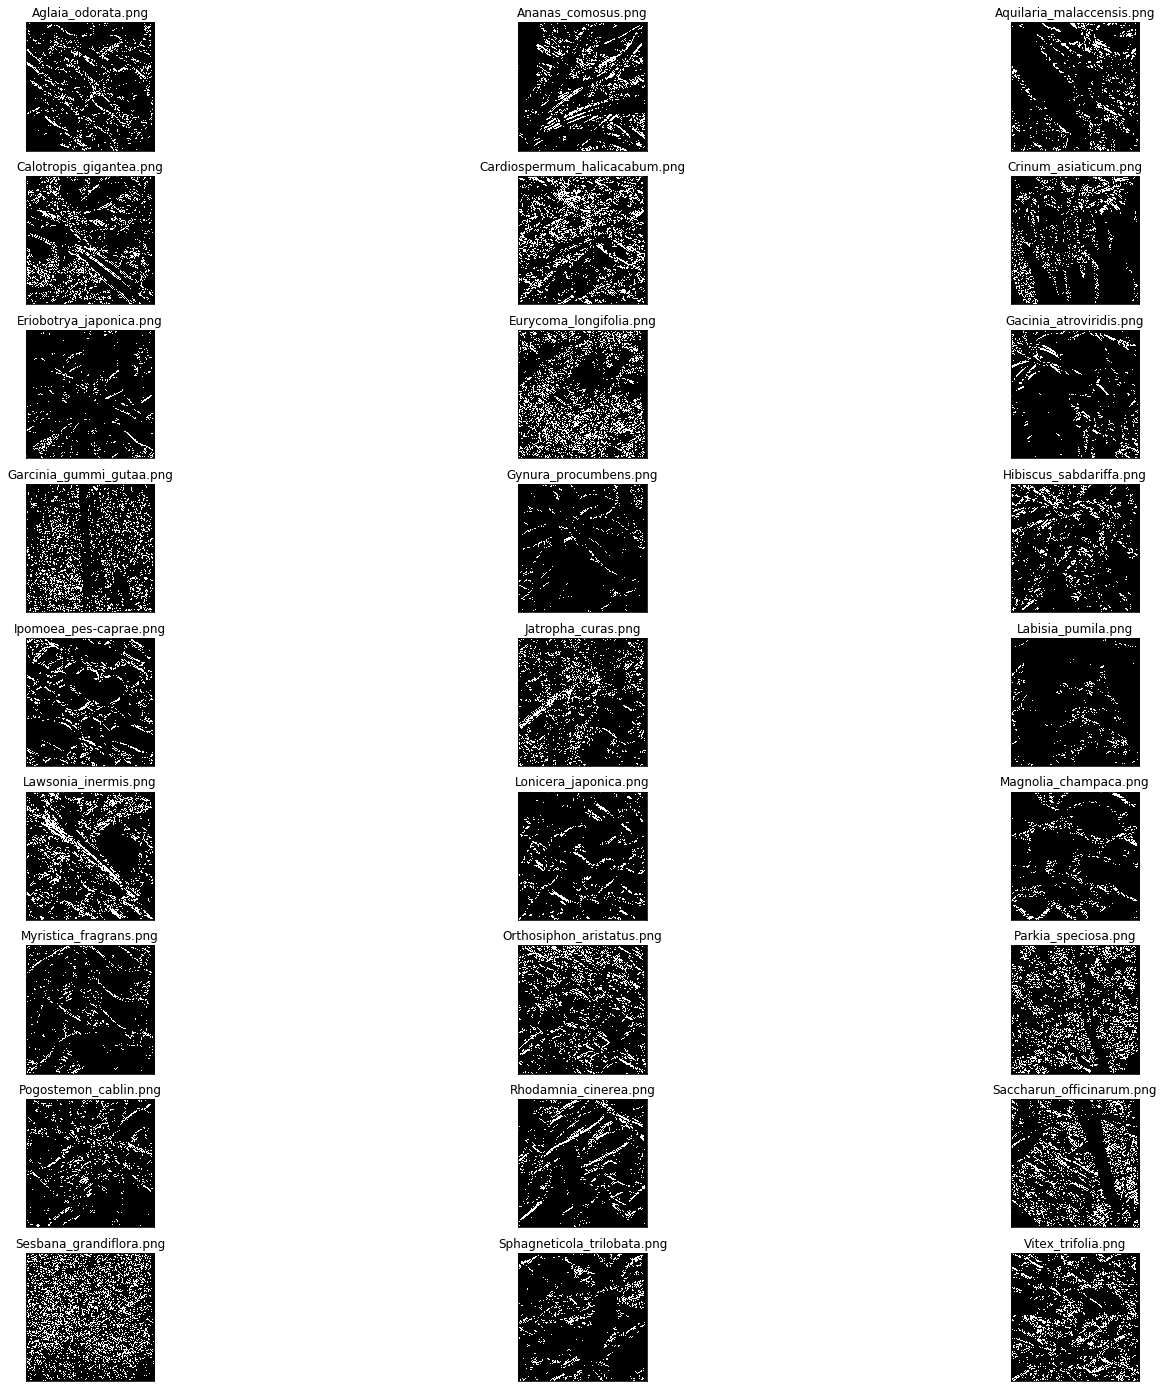

In [24]:
mag_dir_binary_output = applyAndShow(undistort_images, mag_threshold=(20,150), dir_threshold=(0.7,1.3), action='mag_dir_combined')

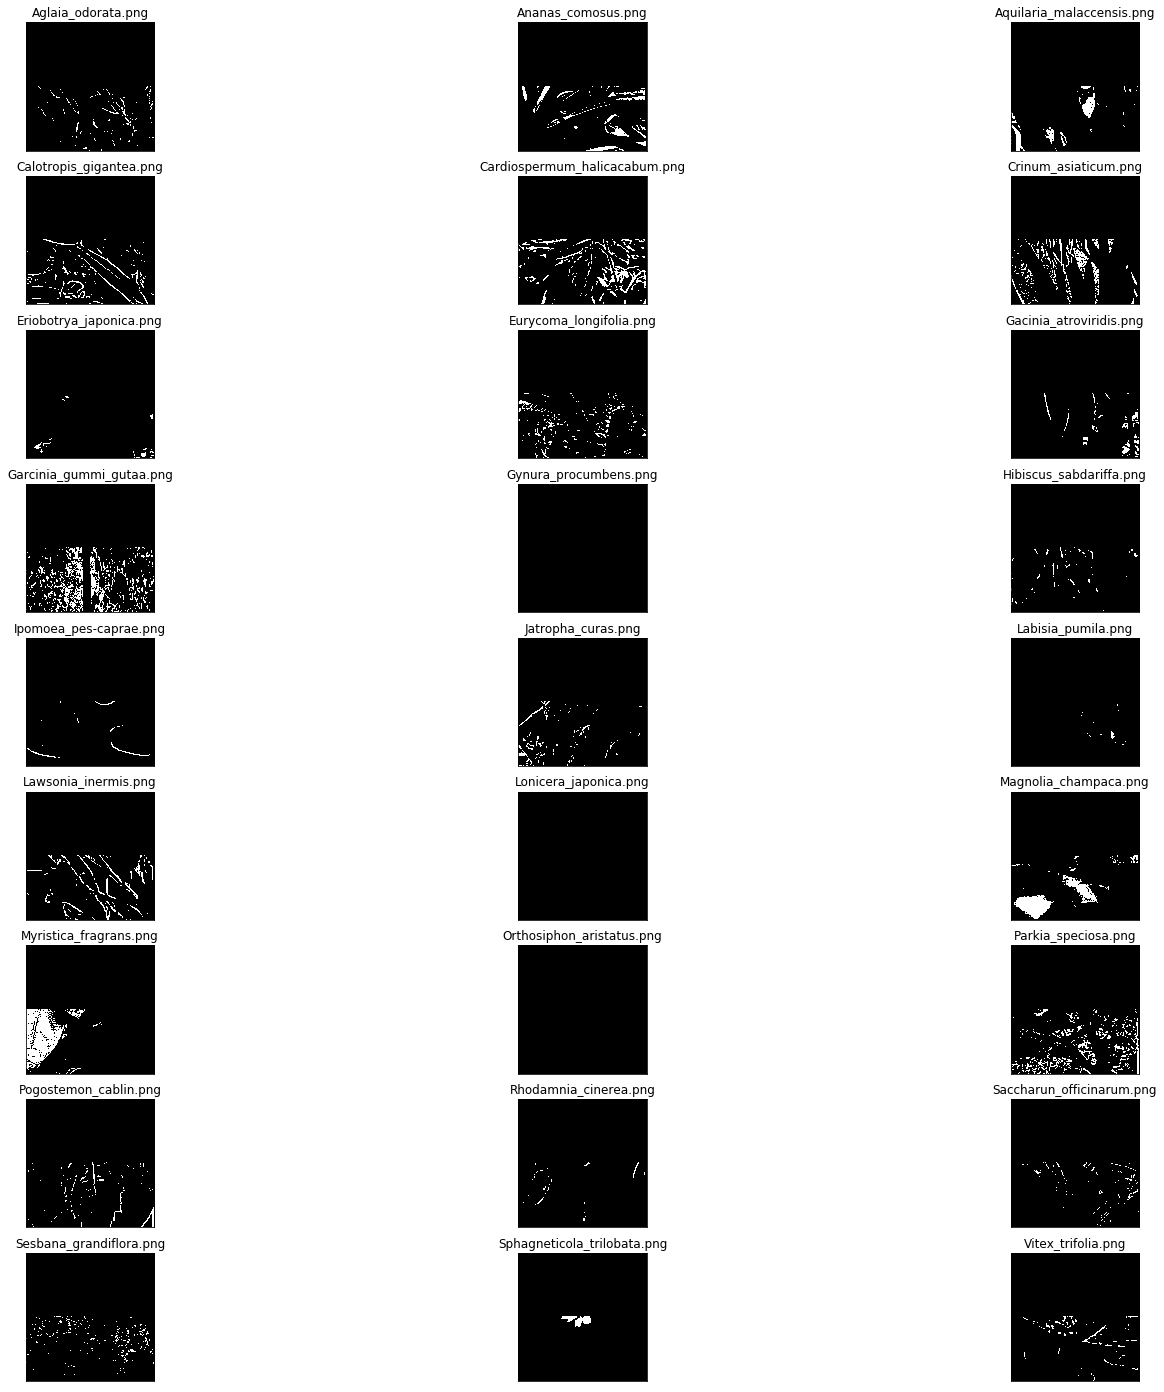

In [25]:
laplacian_binary_output = applyAndShow(undistort_images, action='laplacian_s_channel_combined')

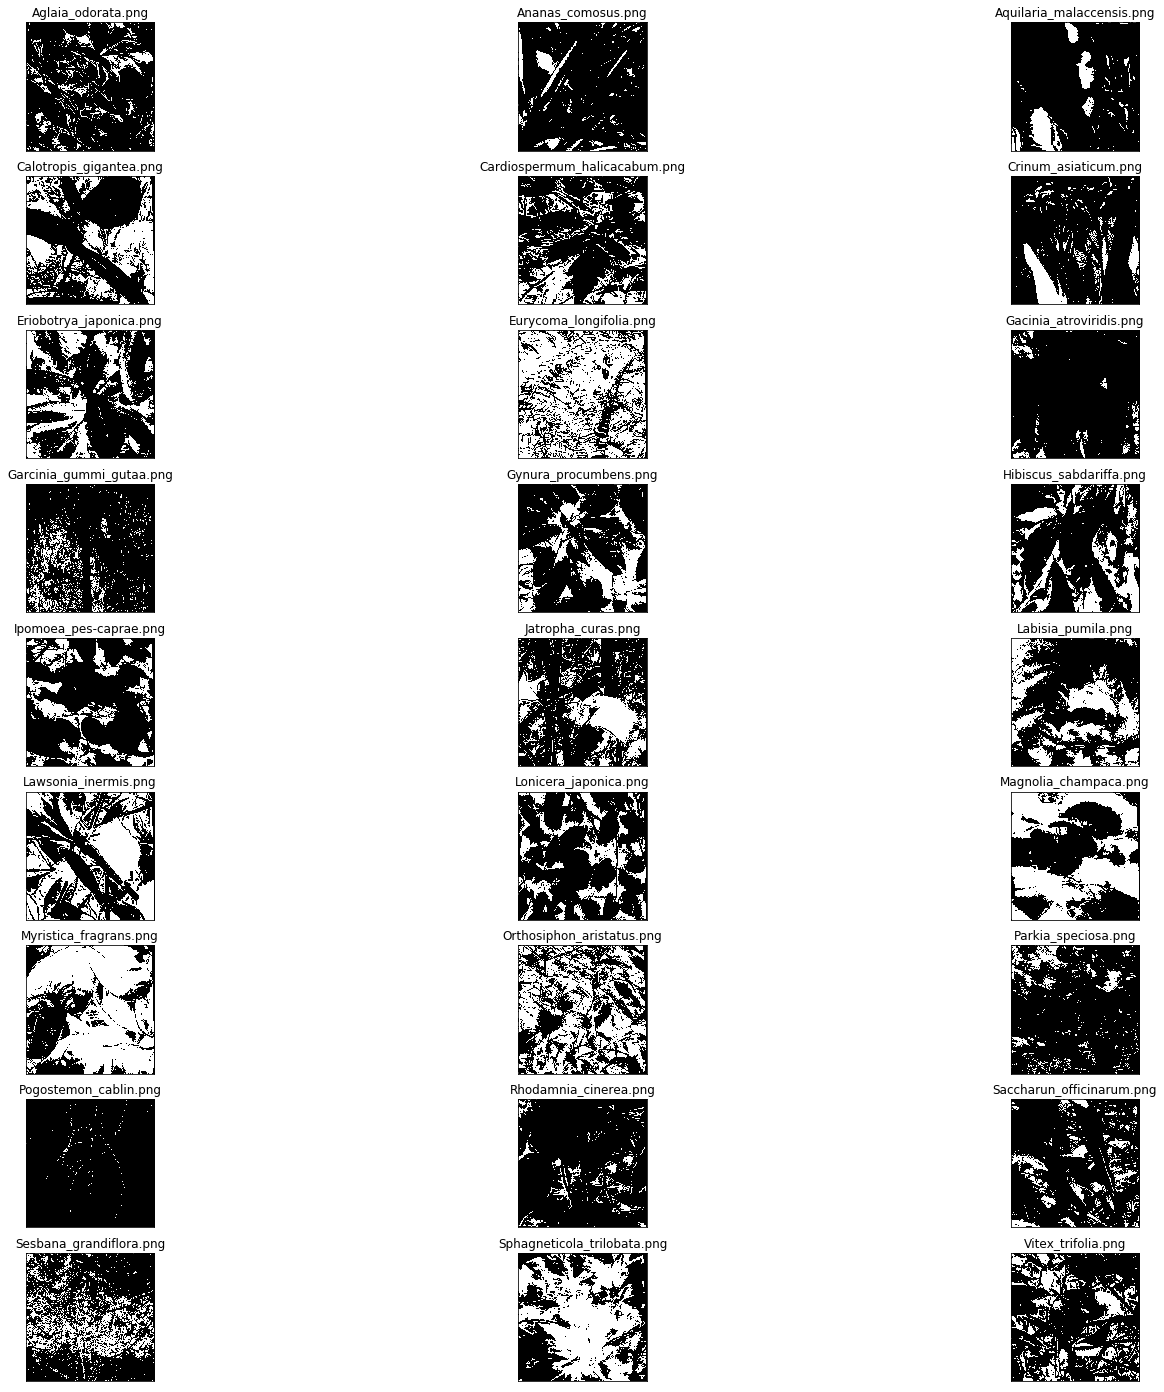

In [26]:
hls_binary_output = applyAndShow(undistort_images,  mag_threshold=(190,255), action='hls_s_channel')

In [27]:
def calc_columns_rows(n):
    """
    Calculate the number of columns and rows required to divide an image
    into 'n' parts.
    """
    num_columns = int(ceil(sqrt(n)))
    num_rows = int(ceil(n / float(num_columns)))
    return (num_columns, num_rows)

In [28]:
def slice(filename, number_tiles, save=True):
    """
    Split an image into a specified number of slices.
    """
    img = cv2.imread(filename)

    im_h, im_w = img.shape[:2]
    columns, rows = calc_columns_rows(number_tiles)
    extras = (columns * rows) - number_tiles
    tile_w, tile_h = int(floor(im_w / columns)), int(floor(im_h / rows))

    tiles = []
    sliced_images = []
    number = 1
    for pos_y in range(0, im_h - rows, tile_h): # -rows for rounding error.
        for pos_x in range(0, im_w - columns, tile_w): # as above.
            crop_img = img[pos_y:pos_y+tile_h, pos_x:pos_x+tile_w]
            sliced_images.append(resizingImage(crop_img))

    save_slices(filename.split('.')[0][:-1] + 'segments/', sliced_images, filename)
    

def save_slices(outFolder, output_images, fileName):
    """
    Write image files to disk. Create specified folder(s) if they
    don't exist. 
    """
       
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    
    for slice_number, img in enumerate(output_images):
        imgName = fileName.split('.')[0].split('/')[1].lower() + '_' + fileName.split('.')[0].split('/')[2] +'_slice' + str(slice_number) + '.jpg' 
        print(imgName)
        outFile = '{0}{1}'.format(outFolder, imgName)
        print(outFile)
        cv2.imwrite(outFile, img)

In [72]:
### Creating Training set

def createTrainDataset():
    
    # Resize image first
    for filename in glob.iglob('train/*/*.png'):
        img = cv2.imread(filename)
        os.remove(filename)
        cv2.imwrite(filename, resizingImage(img))
    
    
    # Image Augmentation
    train_datagen = ImageDataGenerator(
                        rotation_range=15,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.01,
                        zoom_range=[0.9, 1.5],
                        horizontal_flip=True,
                        vertical_flip=False,
                        fill_mode='reflect',
                        brightness_range=[0.5, 2])


    for filePath in glob.iglob('train/*/*.png'):

        folder = 'train_aug/' + filePath.split('/')[1] 

        if not os.path.exists(folder):
            os.makedirs(folder)

        img = load_img(filePath)  # this is a PIL image
        x = img_to_array(img)  # this is a Numpy array with shape (3, 400, 400)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 400, 400)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the respective directory
        i = 0
        for batch in train_datagen.flow(x, batch_size=1,
                                  save_to_dir=folder, save_prefix='file', save_format='png'):
            i += 1
            if i > 20:
                break  # otherwise the generator would loop indefinitely

In [73]:
createTrainDataset()

In [72]:
### Please don't run it again as I already ran it

def createTestDataset():
    for each in list(glob.iglob('test/*/*.png', recursive=True)):
        slice(each, 16)

['test/Aglaia_odorata/1.png',
 'test/Aglaia_odorata/2.png',
 'test/Aglaia_odorata/3.png',
 'test/Ananas_comosus/1.png',
 'test/Ananas_comosus/2.png',
 'test/Aquilaria_malaccensis/1.png',
 'test/Calotropis_gigantea/1.png',
 'test/Calotropis_gigantea/2.png',
 'test/Cardiospermum_halicacabum/1.png',
 'test/Cardiospermum_halicacabum/2.png',
 'test/Cardiospermum_halicacabum/3.png',
 'test/Cardiospermum_halicacabum/4.png',
 'test/Crinum_asiaticum/1.png',
 'test/Crinum_asiaticum/2.png',
 'test/Eriobotrya_japonica/1.png',
 'test/Eriobotrya_japonica/2.png',
 'test/Eriobotrya_japonica/3.png',
 'test/Eriobotrya_japonica/4.png',
 'test/Eurycoma_longifolia/1.png',
 'test/Gacinia_atroviridis/1.png',
 'test/Gacinia_atroviridis/2.png',
 'test/Garcinia_gummi_gutaa/1.png',
 'test/Gynura_procumbens/1.png',
 'test/Gynura_procumbens/2.png',
 'test/Gynura_procumbens/3.png',
 'test/Hibiscus_sabdariffa/1.png',
 'test/Hibiscus_sabdariffa/2.png',
 'test/Ipomoea_pes-caprae/1.png',
 'test/Ipomoea_pes-caprae/2.png

In [87]:
def cleaning():

    root_src_dir = 'test/*/segments/*'
    root_target_dir = 'data/testing/'

    if not os.path.exists(root_target_dir):
        os.mkdir(root_target_dir)

    for each_file in glob.iglob(root_src_dir):
        target_folder = root_target_dir + each_file.split('/')[1] + '/'
        if not os.path.exists(target_folder):
            os.mkdir(target_folder)
        shutil.move(each_file, target_folder)

In [89]:
class Config():
    training_dir = "./data/training/"
    testing_dir = "./data/testing/"
    train_batch_size = 64
    train_number_epochs = 100

In [93]:
base_class_name = 'plant'

In [94]:
img = cv2.imread('data/training/Aglaia_odorata/file_0_1398.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (400, 400, 3)
The number of features in any image from the data set are: 480000


In [108]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1, len(os.listdir('data/training/'))+1):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

classes = gen_class_names(base_class_name)


In [105]:
labels = generate_one_hot_encoding(classes)

In [150]:
def createClassDictionary():
    class_dictn = {}
    for index, class_label in enumerate(os.listdir('data/training/')):
        class_dictn[class_label] = index
    return class_dictn

class_dictn = createClassDictionary()

In [151]:
class_dictn

{'Aglaia_odorata': 0,
 'Ananas_comosus': 1,
 'Aquilaria_malaccensis': 2,
 'Calotropis_gigantea': 3,
 'Cardiospermum_halicacabum': 4,
 'Crinum_asiaticum': 5,
 'Eriobotrya_japonica': 6,
 'Eurycoma_longifolia': 7,
 'Gacinia_atroviridis': 8,
 'Garcinia_gummi_gutaa': 9,
 'Gynura_procumbens': 10,
 'Hibiscus_sabdariffa': 11,
 'Ipomoea_pes-caprae': 12,
 'Jatropha_curas': 13,
 'Labisia_pumila': 14,
 'Lawsonia_inermis': 15,
 'Lonicera_japonica': 16,
 'Magnolia_champaca': 17,
 'Myristica_fragrans': 18,
 'Orthosiphon_aristatus': 19,
 'Parkia_speciosa': 20,
 'Pogostemon_cablin': 21,
 'Rhodamnia_cinerea': 22,
 'Saccharun_officinarum': 23,
 'Sesbana_grandiflora': 24,
 'Sphagneticola_trilobata': 25,
 'Vitex_trifolia': 26}

In [124]:
save_path = 'data/'

In [153]:
def make_dataset(dataType='train'):
    X = []
    y = []
    dataFolder = 'data/{}ing/*/*.png'.format(dataType)
    for each_file in glob.iglob('data/training/*/*.png'):
        X_current, y_current = cv2.imread(each_file), each_file.split('/')[2]
        X.append(X_current)
        label = class_dictn[y_current]
        y.append(label)

    return np.array(X), np.array(y)

In [154]:
X_train, y_train = make_dataset('train')
X_test, y_test = make_dataset('test')

In [155]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X_train,y_train),f)


with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((X_test,y_test),f)

In [146]:
X_train.shape, y_train.shape

((566, 400, 400, 3), (566,))

In [149]:
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt((K.square(u - v)).sum(axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [162]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
input_shape = X_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(len(os.listdir('data/training/'))+1)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Train on 1026 samples, validate on 1026 samples
Epoch 1/10
1026/1026 [==============================] - 154s 150ms/step - loss: 2305657631.6823 - accuracy: 0.5000 - val_loss: 2594871.3096 - val_accuracy: 0.5000
Epoch 2/10
1026/1026 [==============================] - 93s 91ms/step - loss: 3296136.1092 - accuracy: 0.5000 - val_loss: 539272.2304 - val_accuracy: 0.4971
Epoch 3/10
1026/1026 [==============================] - 67s 65ms/step - loss: 619146.7690 - accuracy: 0.5166 - val_loss: 145261.0843 - val_accuracy: 0.5244
Epoch 4/10
1026/1026 [==============================] - 46s 45ms/step - loss: 169791.6221 - accuracy: 0.5097 - val_loss: 76035.9289 - val_accuracy: 0.5127
Epoch 5/10
1026/1026 [==============================] - 59s 58ms/step - loss: 86562.3773 - accuracy: 0.5058 - val_loss: 21459.9346 - val_accuracy: 0.5029
Epoch 6/10
1026/1026 [==============================] - 69s 67ms/step - loss: 32800.8028 - accuracy: 0.5117 - val_loss: 6316.5191 - val_accuracy: 0.5049
Epoch 7/10
102

In [161]:
num_classes = 27
epochs = 10